<a href="https://colab.research.google.com/github/callumselv/Y4_project/blob/main/Lohani_2021_3d_layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install qutip

In [5]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/ColabPackages')

import qutip as qt

# Verify the installation
print(qt.__version__)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


NameError: name 'cy' is not defined

In [2]:
import numpy as np
from qutip import *
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
from scipy.stats import unitary_group
from scipy.linalg import sqrtm

In [3]:
from matplotlib.pyplot import rcParams
rcParams['font.size'] = '16'
rcParams['xtick.direction'] = 'in'
rcParams['ytick.direction'] = 'in'
rcParams['figure.figsize'] = (8, 5)

In [4]:
no_data = 30000
d = 3
dimension = 2**d

In [5]:
def gen_rhos_chos(no_data, d):
    dimension = 2**d
    rhos = np.zeros((no_data,dimension,dimension),dtype=complex)

    eta = 1e-7

    # Generate random density matrices with eta adjustment to avoid issues in Cholesky decomposition
    for i in range(no_data):
        random_unitary = unitary_group.rvs(dimension)
        coeffs = random_unitary[:,0]
        rho = np.outer(coeffs,coeffs.conj())
        rhos[i] = (1-eta)*rho + (eta/4)*np.eye(dimension)

    # Calculate Cholesky decomposition of density matrices
    cholesky_decompositions = np.array([np.linalg.cholesky(rho) for rho in rhos])

    return rhos,cholesky_decompositions

In [6]:
def generate_index_pairs(d):
    dimension = 2**d
    index_num = int(dimension*(dimension-1)/2)
    pairs = np.zeros((index_num,2), dtype=int)
    index=0
    for diff in range(1, dimension):
        for i in range(diff, dimension):
            j = i - diff
            pairs[index] = (i, j)
            index+=1

    return pairs

In [7]:
ind = generate_index_pairs(d)
ind

array([[1, 0],
       [2, 1],
       [3, 2],
       [4, 3],
       [5, 4],
       [6, 5],
       [7, 6],
       [2, 0],
       [3, 1],
       [4, 2],
       [5, 3],
       [6, 4],
       [7, 5],
       [3, 0],
       [4, 1],
       [5, 2],
       [6, 3],
       [7, 4],
       [4, 0],
       [5, 1],
       [6, 2],
       [7, 3],
       [5, 0],
       [6, 1],
       [7, 2],
       [6, 0],
       [7, 1],
       [7, 0]])

In [8]:
def gen_taus(no_data, d):
    rhos, cholesky_decompositions = gen_rhos_chos(no_data, d)

    dimension = 2**d
    tau_size = dimension**2

    all_taus = np.zeros((no_data, tau_size))
    indices = generate_index_pairs(d)

    for no in range(no_data):
        cholesky = cholesky_decompositions[no]
        extracted_values = np.zeros(tau_size)

        index=0
        for i in range(cholesky.shape[0]):
            extracted_values[i] = cholesky[i, i].real

        index = cholesky.shape[0]
        for i, j in indices:
            extracted_values[index] = cholesky[i, j].real
            extracted_values[index + 1] = cholesky[i, j].imag
            index += 2

        all_taus[no] = extracted_values

    return all_taus

In [9]:
# Make 6^d projectors of Pauli {X,Y,Z} operators

paulis = [sigmax(),sigmay(),sigmaz()]
evectors = np.zeros((6,2,1),dtype=complex)

i=0
for pauli in paulis:
    vals, vecs = pauli.eigenstates()
    evectors[i] = vecs[0][:]
    evectors[i+1] = vecs[1][:]
    i += 2

projectors = np.zeros((6,2,2), dtype=complex)

for i, vectors in enumerate(evectors):
    projectors[i] = np.outer(vectors,vectors.conj())

In [10]:
pauli_2d = np.zeros((6**2,4,4), dtype=complex)

index=0
for i in projectors:
    for j in projectors:
        pauli_2d[index] = np.kron(i,j)
        index += 1

In [11]:
pauli_3d = np.zeros((6**3,2**3,2**3), dtype=complex)

index=0
for i in pauli_2d:
    for j in projectors:
        pauli_3d[index] = np.kron(i,j)
        index += 1

In [12]:
pauli_4d = np.zeros((6**4,2**4,2**4), dtype=complex)

index=0
for i in pauli_3d:
    for j in projectors:
        pauli_4d[index] = np.kron(i,j)
        index += 1

In [24]:
def gen_nvals_taus_rhos(no_data, d):
    rhos, cholesky_decompositions = gen_rhos_chos(no_data, d)

    dimension = 2**d
    tau_size = dimension**2

    all_taus = np.zeros((no_data, tau_size))
    indices = generate_index_pairs(d)

    for no in range(no_data):
        cholesky = cholesky_decompositions[no]
        extracted_values = np.zeros(tau_size)

        index_tau=0
        for i in range(cholesky.shape[0]):
            extracted_values[i] = cholesky[i, i].real

        index_tau = cholesky.shape[0]
        for i, j in indices:
            extracted_values[index_tau] = cholesky[i, j].real
            extracted_values[index_tau + 1] = cholesky[i, j].imag
            index_tau += 2

        all_taus[no] = extracted_values

    nvals = np.zeros((no_data,6**d))

    for i1,rho in enumerate(rhos):
      for index,proj in enumerate(pauli_3d):
          nvals[i1,index] = np.trace(rho@proj)

    return nvals, all_taus, rhos

In [25]:
# Recontructs density matrix from tau values predicted by neural network

def reconstruct_matrix_nn(taus):
    matrix = np.zeros((dimension, dimension), dtype=np.complex_)

    index = 0
    for i in range(dimension):
        matrix[i, i] = taus[index]
        index += 1

    indices = generate_index_pairs(d)

    for i, j in indices:
        real_part = taus[index]
        imag_part = taus[index + 1]
        matrix[i, j] = real_part + 1j * imag_part
        index += 2

    rho = matrix@(matrix.conj().T)
    rho = rho/np.trace(rho)

    return rho

In [26]:
# Reconstructs density matrix from true tau values

def reconstruct_matrix_t(taus):
    matrix = np.zeros((dimension, dimension), dtype=np.complex_)

    index = 0
    for i in range(dimension):
        matrix[i, i] = taus[index]
        index += 1

    indices = generate_index_pairs(d)

    for i, j in indices:
        real_part = taus[index]
        imag_part = taus[index + 1]
        matrix[i, j] = real_part + 1j * imag_part
        index += 2

    rho = matrix@(matrix.conj().T)

    return rho

In [27]:
def fidelity(rho_t, rho_nn):
    sqrt_nn = sqrtm(rho_nn)
    matrix = sqrt_nn@rho_t@sqrt_nn
    tr = np.trace(sqrtm(matrix))
    return np.abs(tr)**2

In [17]:
def fid_taus(tau_t, tau_nn):
    rho_t = reconstruct_matrix_t(tau_t)
    rho_nn = reconstruct_matrix_nn(tau_nn)
    return fidelity(rho_t, rho_nn)

In [ ]:
# @title
def generate_index_pairs_tf(d):
    dimension = 2 ** d
    pairs_list = []
    for diff in range(1, dimension):
        for i in range(diff, dimension):
            j = i - diff
            pairs_list.append([i, j])
    pairs = tf.constant(pairs_list, dtype=tf.int32)
    return pairs

def reconstruct_matrix_nn_tf(taus, d):
    dimension = 2 ** d

    diag_indices = tf.stack([tf.range(dimension), tf.range(dimension)], axis=1)
    diag_values = tf.cast(taus[:, :dimension], tf.complex64)

    indices = generate_index_pairs_tf(d)
    num_pairs = tf.shape(indices)[0]
    index = dimension

    real_parts = tf.cast(taus[:, index : index + num_pairs], tf.complex64)
    imag_parts = tf.cast(taus[:, index + num_pairs : index + 2 * num_pairs], tf.complex64)
    off_diag_values = real_parts + 1j * imag_parts

    batch_size = tf.shape(taus)[0]
    diag_indices = tf.tile(tf.expand_dims(diag_indices, 0), [batch_size, 1, 1])
    diag_values = tf.expand_dims(diag_values, -1)

    off_diag_indices = tf.tile(tf.expand_dims(indices, 0), [batch_size, 1, 1])
    off_diag_values = tf.expand_dims(off_diag_values, -1)

    all_indices = tf.concat([diag_indices, off_diag_indices], axis=1)
    all_values = tf.concat([diag_values, off_diag_values], axis=1)

    matrix_shape = [dimension, dimension]
    matrices = tf.map_fn(
        lambda x: tf.scatter_nd(x[0], tf.squeeze(x[1]), matrix_shape),
        (all_indices, all_values),
        fn_output_signature=tf.complex64
    )

    # Compute rho = matrix @ matrix.conj().T
    matrices_dagger = tf.linalg.adjoint(matrices)
    rhos = tf.matmul(matrices, matrices_dagger)

    traces = tf.linalg.trace(rhos)
    traces = tf.reshape(traces, [-1, 1, 1])
    rhos_normalized = rhos / traces

    return rhos_normalized

def reconstruct_matrix_t_tf(taus, d):
    dimension = 2 ** d

    diag_indices = tf.stack([tf.range(dimension), tf.range(dimension)], axis=1)
    diag_values = tf.cast(taus[:, :dimension], tf.complex64)

    indices = generate_index_pairs_tf(d)
    num_pairs = tf.shape(indices)[0]
    index = dimension

    real_parts = tf.cast(taus[:, index : index + num_pairs], tf.complex64)
    imag_parts = tf.cast(taus[:, index + num_pairs : index + 2 * num_pairs], tf.complex64)
    off_diag_values = real_parts + 1j * imag_parts

    batch_size = tf.shape(taus)[0]
    diag_indices = tf.tile(tf.expand_dims(diag_indices, 0), [batch_size, 1, 1])
    diag_values = tf.expand_dims(diag_values, -1)

    off_diag_indices = tf.tile(tf.expand_dims(indices, 0), [batch_size, 1, 1])
    off_diag_values = tf.expand_dims(off_diag_values, -1)

    all_indices = tf.concat([diag_indices, off_diag_indices], axis=1)
    all_values = tf.concat([diag_values, off_diag_values], axis=1)

    matrix_shape = [dimension, dimension]
    matrices = tf.map_fn(
        lambda x: tf.scatter_nd(x[0], tf.squeeze(x[1]), matrix_shape),
        (all_indices, all_values),
        fn_output_signature=tf.complex64
    )

    # Compute rho = matrix @ matrix.conj().T
    matrices_dagger = tf.linalg.adjoint(matrices)
    rhos = tf.matmul(matrices, matrices_dagger)

    return rhos

'''
def fidelity_tf(rho_t, rho_nn):
    sqrt_nn = tf.linalg.sqrtm(rho_nn)
    intermediate = tf.matmul(sqrt_nn, tf.matmul(rho_t, sqrt_nn))
    sqrt_intermediate = tf.linalg.sqrtm(intermediate)
    trace = tf.math.real(tf.linalg.trace(sqrt_intermediate))
    fidelity = tf.square(tf.abs(trace))
    return fidelity
'''

def fidelity_tf(rho_t, rho_nn):
    product = tf.matmul(rho_t, rho_nn)
    trace = tf.linalg.trace(product)
    return tf.abs(trace)


def fid_taus_tf(tau_t, tau_nn, d):
    rho_t = reconstruct_matrix_t_tf(tau_t, d)
    rho_nn = reconstruct_matrix_nn_tf(tau_nn, d)
    fidelities = fidelity_tf(rho_t, rho_nn)
    return fidelities

In [ ]:
def fidelity_metric(y_true, y_pred):
    return fid_taus_tf(y_true, y_pred, d)

In [18]:
dense1 = 2500
dense2 = 1000

In [19]:
def build_cnn_model():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 36, 1), input_shape=(6**d,)))

    model.add(Conv2D(filters=25, kernel_size=(2, 2), strides=1, activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=25, kernel_size=(2, 2), strides=1, activation='relu'))

    model.add(Flatten())

    model.add(Dense(dense1, activation='relu'))

    model.add(Dense(dense2, activation='relu'))

    model.add(Dense(2**(2*d), activation='linear'))

    return model

model = build_cnn_model()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape (Reshape)                    │ (None, 6, 36, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 5, 35, 25)           │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 2, 17, 25)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 1, 16, 25)           │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 2500)                │       1,002,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1000)                │       2,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │          64,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,570,214 (13.62 MB)

 Trainable params: 3,570,214 (13.62 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
from tensorflow.keras.callbacks import EarlyStopping

In [28]:
nvals,all_taus,rhos = gen_nvals_taus_rhos(30000,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [29]:
import time

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs=None):
        self.epoch_times = []
        self.train_start_time = time.time()
        self.cumulative_times = []

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()

    def on_epoch_end(self, epoch, logs=None):
        epoch_duration = time.time() - self.epoch_start_time
        self.epoch_times.append(epoch_duration)
        cumulative_time = time.time() - self.train_start_time
        self.cumulative_times.append(cumulative_time)


In [30]:
class InMemoryModelSaver(tf.keras.callbacks.Callback):
    def __init__(self, save_freq_epochs=20):
        super(InMemoryModelSaver, self).__init__()
        self.save_freq_epochs = save_freq_epochs
        self.saved_models = {}

    def on_epoch_end(self, epoch, logs=None):
        epoch_num = epoch + 1

        if (epoch_num - 1) % self.save_freq_epochs == 0:
            cloned_model = tf.keras.models.clone_model(self.model)

            cloned_model.compile(
                optimizer=self.model.optimizer.__class__.from_config(self.model.optimizer.get_config()),
                loss=self.model.loss,
                metrics=self.model.metrics
            )

            cloned_model.set_weights(self.model.get_weights())

            self.saved_models[epoch_num] = cloned_model

            print(f'\n[InMemoryModelSaver] Model cloned and saved in memory at epoch {epoch_num}.')

In [31]:
def build_cnn_model_layers():
    model = Sequential()

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model
model = build_cnn_model_layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_5 (Dense)                      │ (None, 2500)                │         542,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │         160,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 702,564 (2.68 MB)

 Trainable params: 702,564 (2.68 MB)

 Non-trainable params: 0 (0.00 B)

In [32]:
time_callback1 = TimeHistory()

model1_layer = build_cnn_model_layers()
model1_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver1 = InMemoryModelSaver(save_freq_epochs=10)

history1 = model1_layer.fit(
    nvals, all_taus,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback1, model_saver1]
    )

Epoch 1/300
230/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0461 - mean_squared_error: 0.0094
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0454 - mean_squared_error: 0.0092 - val_loss: 0.0160 - val_mean_squared_error: 0.0017
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0139 - mean_squared_error: 0.0014 - val_loss: 0.0102 - val_mean_squared_error: 8.7849e-04
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0096 - mean_squared_error: 8.2814e-04 - val_loss: 0.0084 - val_mean_squared_error: 6.1501e-04
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0078 - mean_squared_error: 5.8014e-04 - val_loss: 0.0071 - val_mean_squared_error: 4.7337e-04
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0068 - mean_squared_error: 4.6095e-04 - val_loss: 0.0064 - val_mean_squared_error: 4.2118e-04
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0062 - mean_s

Text(0, 0.5, 'Validation loss')

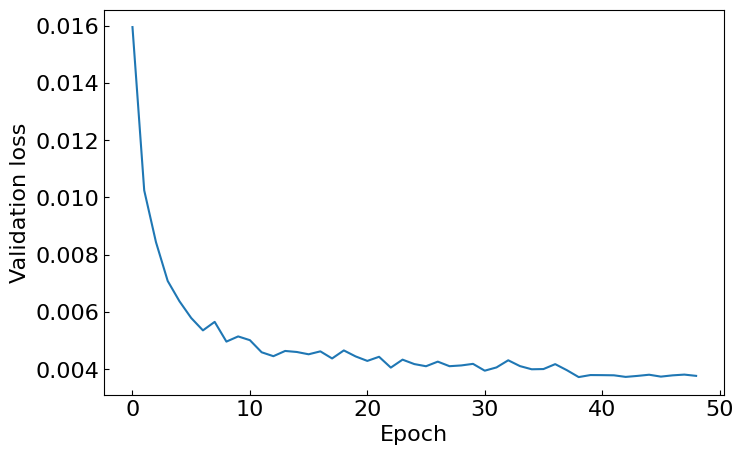

In [33]:
plt.plot(history1.history['val_loss'])
plt.xlabel('Epoch')
plt.ylabel('Validation loss')

In [34]:
len(history1.history['val_loss'])

49

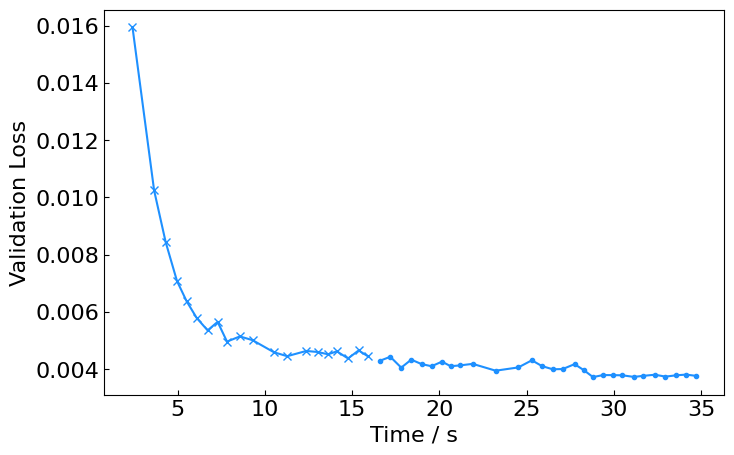

In [35]:
epoch_durations1 = time_callback1.epoch_times
cumulative_times1 = time_callback1.cumulative_times
change_mark = 20

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='Training Loss', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [36]:
test_no = 500
n_tests, tau_tests, rho_tests = gen_nvals_taus_rhos(test_no,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [37]:
def predict_with_saved_models(saved_models, epochs_to_predict, X_input):
    predictions = {}

    for epoch_num in epochs_to_predict:
        model = saved_models.get(epoch_num)
        if model is not None:
            preds = model.predict(X_input)
            predictions[epoch_num] = preds
    return predictions

In [38]:
epochs = len(history1.history['val_loss'])

epochs_saved = np.arange(1,epochs,10)

In [39]:
tau_nns_int = predict_with_saved_models(model_saver1.saved_models, epochs_saved, n_tests)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


In [40]:
fidelities_int = np.zeros((len(epochs_saved),test_no))
fidelities_plot = np.zeros(len(epochs_saved))
fidelities_int_err = np.zeros(len(epochs_saved))
for index,val in enumerate(epochs_saved):
    i=0
    for nns, tests in zip(tau_nns_int[val],tau_tests):
        fidelities_int[index,i] = fid_taus(tests,nns)
        i+=1
    fidelities_int_err[index] = np.std(fidelities_int[index])/np.sqrt(test_no)
    fidelities_plot[index] = np.mean(fidelities_int[index])

In [41]:
tau_nns = model1_layer.predict(n_tests)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [42]:
fidelities = np.zeros(len(tau_nns))
index = 0
fid = 0
for nns, tests in zip(tau_nns,tau_tests):
    fid += fid_taus(tests,nns)
    fidelities[index] = fid_taus(tests,nns)
    index += 1
fid_err = np.std(fidelities)/np.sqrt(test_no)
fid = np.mean(fidelities)

In [43]:
fidelities = np.append(fidelities_plot,fid)
fidelities_err = np.append(fidelities_int_err, fid_err)

In [44]:
epochs_fin = np.append(epochs_saved,epochs)
epochs_fin

array([ 1, 11, 21, 31, 41, 49])

In [45]:
times_saved = np.zeros(len(epochs_fin))
index=0
for i in epochs_fin:
    times_saved[index] = cumulative_times1[i-1]
    index+=1

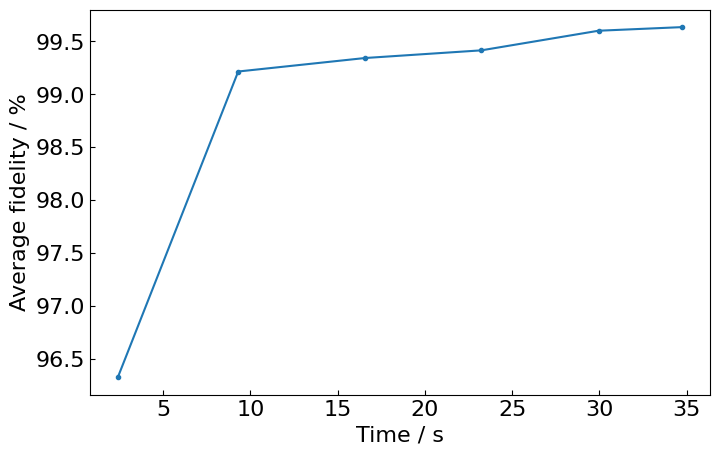

In [46]:
plt.errorbar(times_saved, fidelities*100, yerr=fidelities_err, linestyle = '-', marker='.')
plt.xlabel('Time / s')
plt.ylabel('Average fidelity / %')
plt.show()

In [47]:
print(f'Average fidelity over {len(tau_nns)} test matrices is {np.mean(fidelities)*100:.2f} ± {np.std(fidelities)*100/np.sqrt(len(fidelities)):.2f} %')

Average fidelity over 500 test matrices is 98.92 ± 0.48 %


In [48]:
def build_cnn_model_2layers():
    model = Sequential()

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_2layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                      │ (None, 2500)                │         542,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1000)                │       2,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │          64,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,107,564 (11.85 MB)

 Trainable params: 3,107,564 (11.85 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
nvals2,all_taus2,rhos2 = gen_nvals_taus_rhos(30000,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [50]:
time_callback2 = TimeHistory()

model2_layer = build_cnn_model_2layers()
model2_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver2 = InMemoryModelSaver(save_freq_epochs=10)

history2 = model1_layer.fit(
    nvals2, all_taus2,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback2, model_saver2]
    )

Epoch 1/300
236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0041 - mean_squared_error: 2.0253e-04
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0041 - mean_squared_error: 2.0262e-04 - val_loss: 0.0042 - val_mean_squared_error: 2.0472e-04
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0041 - mean_squared_error: 2.0824e-04 - val_loss: 0.0039 - val_mean_squared_error: 1.9373e-04
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 0.0040 - mean_squared_error: 1.9299e-04 - val_loss: 0.0041 - val_mean_squared_error: 1.9553e-04
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0039 - mean_squared_error: 1.9098e-04 - val_loss: 0.0042 - val_mean_squared_error: 2.1310e-04
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.0039 - mean_squared_error: 1.9508e-04 - val_loss: 0.0041 - val_mean_squared_error: 1.9736e-04
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss:

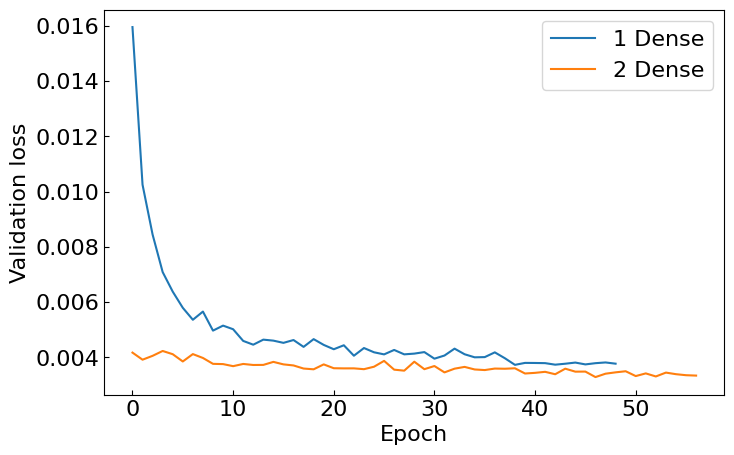

In [51]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()

In [52]:
len(history2.history['val_loss'])

57

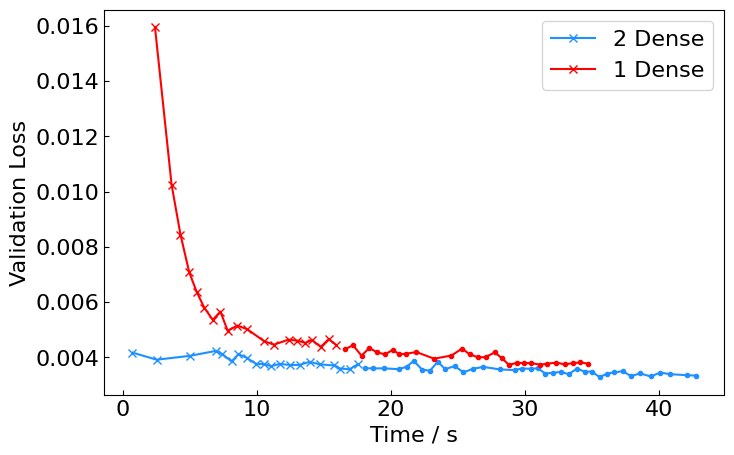

In [53]:
cumulative_times2 = time_callback2.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [54]:
n_tests2, tau_tests2, rho_tests2 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [55]:
epochs2 = len(history2.history['val_loss'])

epochs_saved2 = np.arange(1,epochs2,10)

tot_epochs2 = np.append(epochs_saved2, epochs2)

In [56]:
tau_nns_int2 = predict_with_saved_models(model_saver2.saved_models, epochs_saved2, n_tests2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [57]:
tau_nns2 = model2_layer.predict(n_tests2)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


In [58]:
def fidelities_epochs(tau_nns, tau_tests, tau_nns_int, epochs_saved, epochs, cumulative_times, test_no=test_no):

    fidelities_int = np.zeros((len(epochs_saved),test_no))
    fidelities_plot = np.zeros(len(epochs_saved))
    fidelities_int_err = np.zeros(len(epochs_saved))

    for idx, epoch in enumerate(epochs_saved):
        for test_idx, (nns, tests) in enumerate(zip(tau_nns_int[epoch], tau_tests)):
            fidelities_int[idx, test_idx] = fid_taus(tests, nns)
        fidelities_plot[idx] = np.mean(fidelities_int[idx])
        fidelities_int_err[idx] = np.std(fidelities_int[idx]) / np.sqrt(test_no)

    fidelities = np.zeros(len(tau_nns))
    index = 0
    for nns, tests in zip(tau_nns,tau_tests):
        fidelities[index] = fid_taus(tests,nns)
        index += 1
    fid_err = np.std(fidelities)/np.sqrt(test_no)
    fid = np.mean(fidelities)

    fidelities = np.append(fidelities_plot,fid)
    fidelities_err = np.append(fidelities_int_err, fid_err)

    epochs_fin = np.append(epochs_saved,epochs)
    times_saved = np.zeros(len(epochs_fin))
    index=0
    for i in epochs_fin:
        times_saved[index] = cumulative_times[i-1]
        index+=1

    return times_saved, fidelities, fidelities_err

In [59]:
times_saved2, fidelities2, fidelities_err2 = fidelities_epochs(tau_nns2, tau_tests2, tau_nns_int2, epochs_saved2, epochs2, cumulative_times2)

In [60]:
times_saved1, fidelities1, fidelities_err1 = fidelities_epochs(tau_nns, tau_tests, tau_nns_int, epochs_saved, epochs, cumulative_times1)

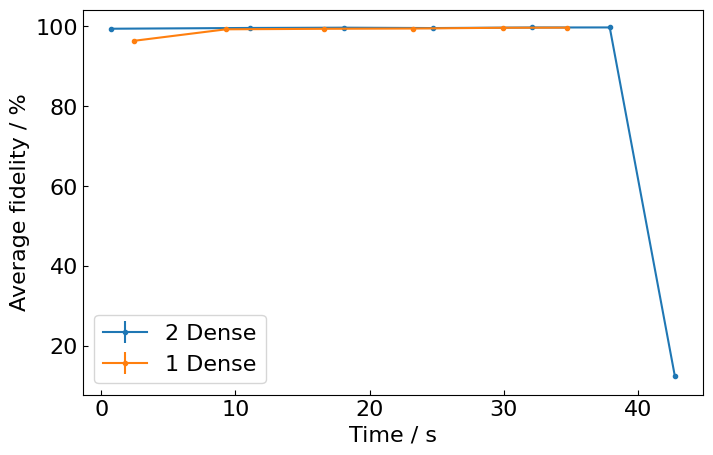

In [61]:
plt.errorbar(times_saved2, fidelities2*100, yerr=fidelities_err2*100, linestyle = '-', marker='.', label = '2 Dense')
plt.errorbar(times_saved1, fidelities1*100, yerr=fidelities_err1*100, linestyle = '-', marker='.', label = '1 Dense')
plt.xlabel('Time / s')
plt.ylabel('Average fidelity / %')
plt.legend()
plt.show()

In [64]:
print(f'Average fidelity over {test_no} test matrices is {fidelities2[-2]*100:.2f} ± {fidelities_err2[-2]*100:.2f} %')

Average fidelity over 500 test matrices is 99.68 ± 0.09 %


In [65]:
def build_cnn_model_3layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 36, 1), input_shape=(6**d,)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
    ))

    model.add(Flatten())

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_3layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_1 (Reshape)                  │ (None, 6, 36, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 5, 35, 25)           │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 4375)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 2500)                │      10,940,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 1000)                │       2,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_17 (Dense)                     │ (None, 64)                  │          64,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,505,189 (51.52 MB)

 Trainable params: 13,505,189 (51.52 MB)

 Non-trainable params: 0 (0.00 B)

In [66]:
nvals3,all_taus3,rhos3 = gen_nvals_taus_rhos(30000,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [67]:
time_callback3 = TimeHistory()

model3_layer = build_cnn_model_3layers()
model3_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping3 = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver3 = InMemoryModelSaver(save_freq_epochs=10)

history3 = model3_layer.fit(
    nvals3, all_taus3,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping3, time_callback3, model_saver3]
    )

Epoch 1/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0448 - mean_squared_error: 0.0118
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0448 - mean_squared_error: 0.0118 - val_loss: 0.0149 - val_mean_squared_error: 0.0016
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0125 - mean_squared_error: 0.0012 - val_loss: 0.0091 - val_mean_squared_error: 6.6010e-04
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0084 - mean_squared_error: 6.1327e-04 - val_loss: 0.0076 - val_mean_squared_error: 5.0498e-04
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - loss: 0.0073 - mean_squared_error: 4.7590e-04 - val_loss: 0.0070 - val_mean_squared_error: 4.4581e-04
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0068 - mean_squared_error: 4.1526e-04 - val_loss: 0.0068 - val_mean_squared_error: 4.1032e-04
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0065 - mean_s

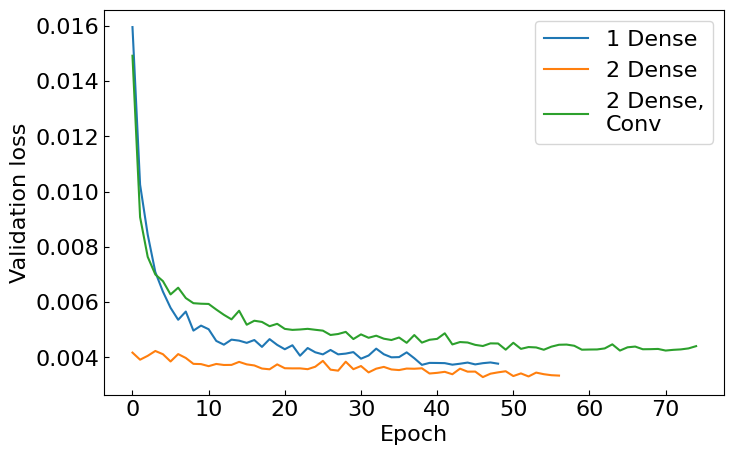

In [68]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.plot(history3.history['val_loss'], label='2 Dense,\nConv')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()

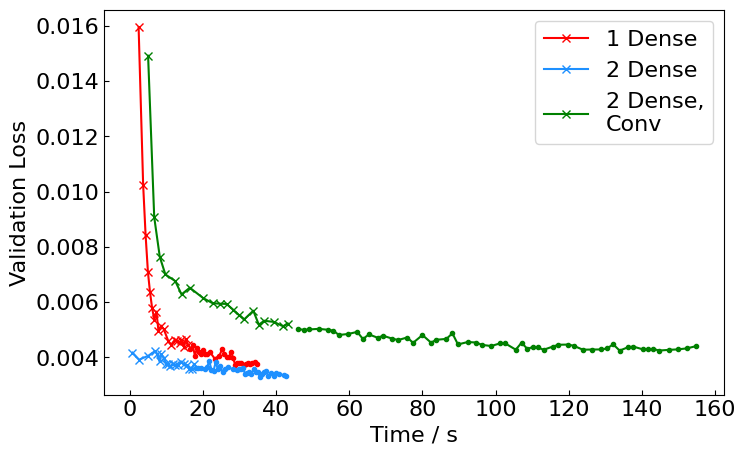

In [69]:
cumulative_times3 = time_callback3.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times3[:20], history3.history['val_loss'][:20], label='2 Dense,\nConv', color='green', linestyle='-', marker='x')
plt.plot(cumulative_times3[20:], history3.history['val_loss'][20:], color='green', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [70]:
n_tests3, tau_tests3, rho_tests3 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [71]:
epochs3 = len(history3.history['val_loss'])
epochs_saved3 = np.arange(1,epochs3,10)

In [72]:
tau_nns_int3 = predict_with_saved_models(model_saver3.saved_models, epochs_saved3, n_tests3)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [73]:
tau_nns3 = model3_layer.predict(n_tests3)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [74]:
times_saved3, fidelities3, fidelities_err3 = fidelities_epochs(tau_nns3, tau_tests3, tau_nns_int3, epochs_saved3, epochs3, cumulative_times3)

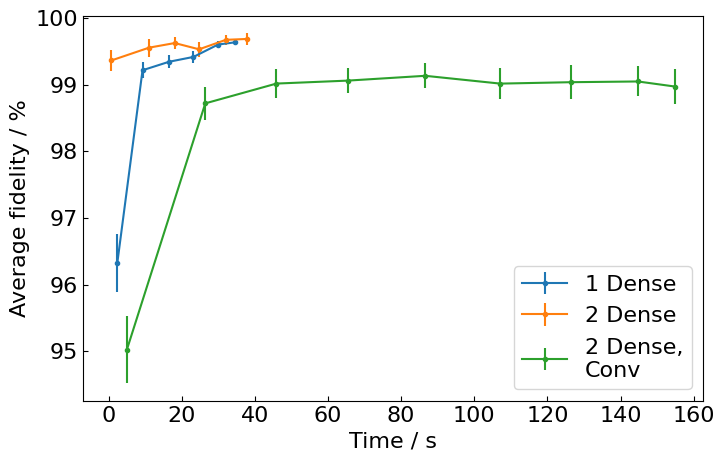

In [77]:
plt.errorbar(times_saved1, (fidelities1)*100, yerr=fidelities_err1*100, linestyle = '-', marker='.', label = '1 Dense')
plt.errorbar(times_saved2[:-1], (fidelities2[:-1])*100, yerr=fidelities_err2[:-1]*100, linestyle = '-', marker='.', label = '2 Dense')
plt.errorbar(times_saved3, (fidelities3)*100, yerr=fidelities_err3*100, linestyle = '-', marker='.', label = '2 Dense,\nConv')
plt.xlabel('Time / s')
plt.ylabel('Average fidelity / %')
plt.legend()
plt.show()

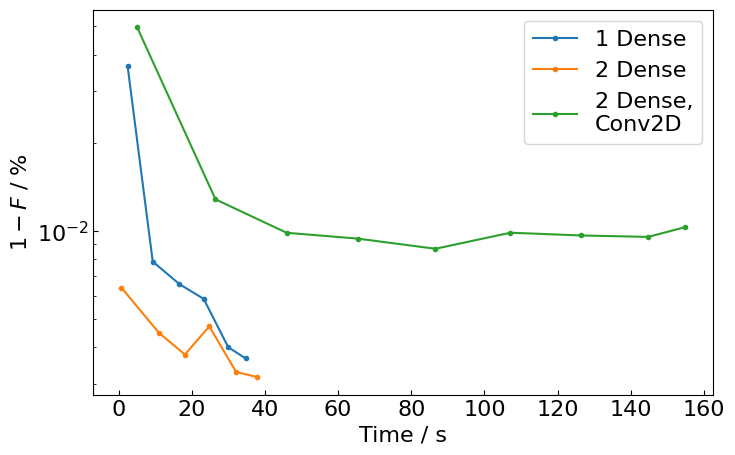

In [76]:
plt.semilogy(times_saved1, (1-fidelities1), linestyle = '-', marker='.', label = '1 Dense')
plt.semilogy(times_saved2[:-1], (1-fidelities2[:-1]), linestyle = '-', marker='.', label = '2 Dense')
plt.semilogy(times_saved3, (1-fidelities3), linestyle = '-', marker='.', label = '2 Dense,\nConv2D')
plt.xlabel('Time / s')
plt.ylabel(r'$1-F$ / %')
plt.legend()
plt.show()

In [ ]:
1-fidelities3

array([7.30103002e-03, 8.59472985e-04, 6.79061728e-04, 4.73482411e-04,
       4.39618451e-04, 1.49484179e-04, 1.24302053e-04, 8.45670387e-05,
       1.22492269e-04])

In [79]:
def build_cnn_model_4layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 36, 1), input_shape=(6**d,)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
    ))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
    ))

    model.add(Flatten())

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_4layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_4 (Reshape)                  │ (None, 6, 36, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 5, 35, 25)           │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 4, 34, 25)           │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 3400)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_21 (Dense)                     │ (None, 2500)                │       8,502,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 1000)                │       2,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 64)                  │          64,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,070,214 (42.23 MB)

 Trainable params: 11,070,214 (42.23 MB)

 Non-trainable params: 0 (0.00 B)

In [80]:
nvals4,all_taus4,rhos4 = gen_nvals_taus_rhos(30000,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [81]:
time_callback4 = TimeHistory()

model4_layer = build_cnn_model_4layers()
model4_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver4 = InMemoryModelSaver(save_freq_epochs=10)

history4 = model4_layer.fit(
    nvals4, all_taus4,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback4, model_saver4]
    )

Epoch 1/300
236/240 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0493 - mean_squared_error: 0.0138
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0491 - mean_squared_error: 0.0137 - val_loss: 0.0185 - val_mean_squared_error: 0.0022
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0151 - mean_squared_error: 0.0016 - val_loss: 0.0093 - val_mean_squared_error: 7.2264e-04
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0091 - mean_squared_error: 6.8421e-04 - val_loss: 0.0078 - val_mean_squared_error: 5.3693e-04
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.0077 - mean_squared_error: 5.2663e-04 - val_loss: 0.0074 - val_mean_squared_error: 4.9298e-04
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0070 - mean_squared_error: 4.3983e-04 - val_loss: 0.0075 - val_mean_squared_error: 4.6738e-04
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0067 - mean_

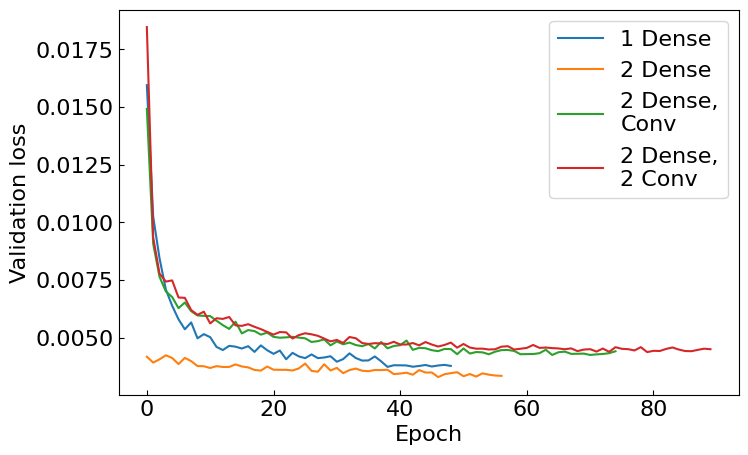

In [82]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.plot(history3.history['val_loss'], label='2 Dense,\nConv')
plt.plot(history4.history['val_loss'], label='2 Dense,\n2 Conv')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()

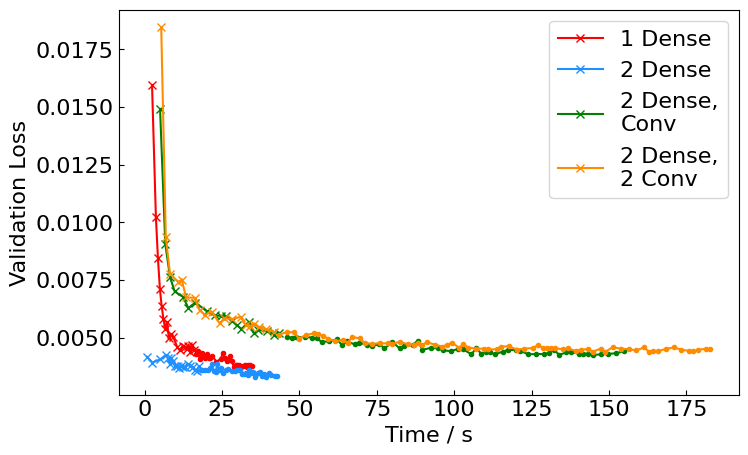

In [83]:
cumulative_times4 = time_callback4.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times3[:20], history3.history['val_loss'][:20], label='2 Dense,\nConv', color='green', linestyle='-', marker='x')
plt.plot(cumulative_times3[20:], history3.history['val_loss'][20:], color='green', linestyle='-', marker='.')
plt.plot(cumulative_times4[:20], history4.history['val_loss'][:20], label='2 Dense,\n2 Conv', color='darkorange', linestyle='-', marker='x')
plt.plot(cumulative_times4[20:], history4.history['val_loss'][20:], color='darkorange', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [84]:
n_tests4, tau_tests4, rho_tests4 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [85]:
epochs4 = len(history4.history['val_loss'])
epochs_saved4 = np.arange(1,epochs4,10)

In [86]:
tau_nns_int4 = predict_with_saved_models(model_saver4.saved_models, epochs_saved4, n_tests4)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [87]:
tau_nns4 = model4_layer.predict(n_tests4)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


In [88]:
times_saved4, fidelities4, fidelities_err4 = fidelities_epochs(tau_nns4, tau_tests4, tau_nns_int4, epochs_saved4, epochs4, cumulative_times4)

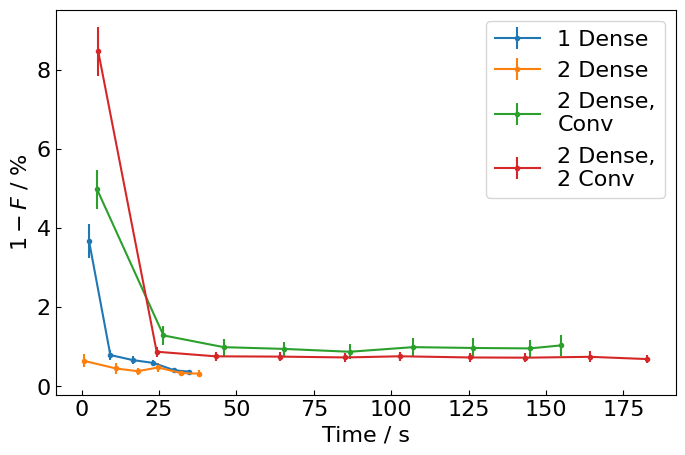

In [89]:
plt.errorbar(times_saved1, (1-fidelities1)*100, yerr=fidelities_err1*100, linestyle = '-', marker='.', label = '1 Dense')
plt.errorbar(times_saved2[:-1], (1-fidelities2[:-1])*100, yerr=fidelities_err2[:-1]*100, linestyle = '-', marker='.', label = '2 Dense')
plt.errorbar(times_saved3, (1-fidelities3)*100, yerr=fidelities_err3*100, linestyle = '-', marker='.', label = '2 Dense,\nConv')
plt.errorbar(times_saved4, (1-fidelities4)*100, yerr=fidelities_err4*100, linestyle = '-', marker='.', label = '2 Dense,\n2 Conv')
plt.xlabel('Time / s')
plt.ylabel(r'$1-F$ / %')
plt.legend()
plt.show()

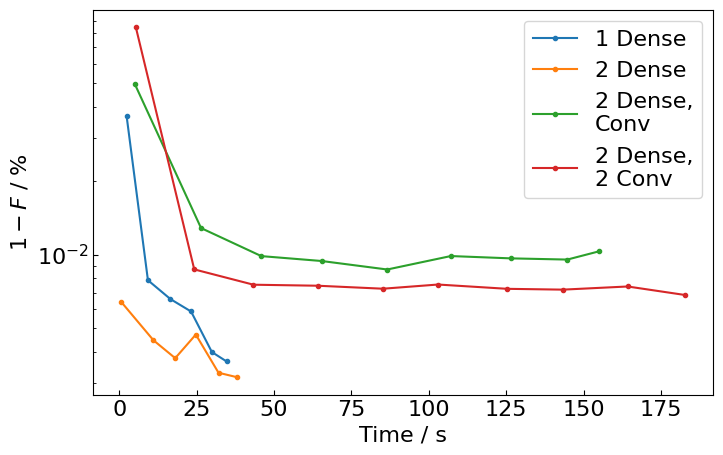

In [90]:
plt.semilogy(times_saved1, (1-fidelities1), linestyle = '-', marker='.', label = '1 Dense')
plt.semilogy(times_saved2[:-1], (1-fidelities2[:-1]), linestyle = '-', marker='.', label = '2 Dense')
plt.semilogy(times_saved3, (1-fidelities3), linestyle = '-', marker='.', label = '2 Dense,\nConv')
plt.semilogy(times_saved4, (1-fidelities4), linestyle = '-', marker='.', label = '2 Dense,\n2 Conv')
plt.xlabel('Time / s')
plt.ylabel(r'$1-F$ / %')
plt.legend()
plt.show()

In [92]:
def build_cnn_model_5layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 36, 1), input_shape=(6**d,)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
    ))


    model.add(Flatten())

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_5layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_7 (Reshape)                  │ (None, 6, 36, 1)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 5, 35, 25)           │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 2, 17, 25)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 1, 16, 25)           │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_5 (Flatten)                  │ (None, 400)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 2500)                │       1,002,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_28 (Dense)                     │ (None, 1000)                │       2,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_29 (Dense)                     │ (None, 64)                  │          64,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,570,214 (13.62 MB)

 Trainable params: 3,570,214 (13.62 MB)

 Non-trainable params: 0 (0.00 B)

In [93]:
nvals5,all_taus5,rhos5 = gen_nvals_taus_rhos(30000,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [94]:
time_callback5 = TimeHistory()

model5_layer = build_cnn_model_5layers()
model5_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver5 = InMemoryModelSaver(save_freq_epochs=10)

history5 = model5_layer.fit(
    nvals5, all_taus5,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback5, model_saver5]
    )

Epoch 1/300
235/240 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0484 - mean_squared_error: 0.0144
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0483 - mean_squared_error: 0.0144 - val_loss: 0.0457 - val_mean_squared_error: 0.0136
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0445 - mean_squared_error: 0.0129 - val_loss: 0.0399 - val_mean_squared_error: 0.0105
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0379 - mean_squared_error: 0.0096 - val_loss: 0.0325 - val_mean_squared_error: 0.0073
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0304 - mean_squared_error: 0.0065 - val_loss: 0.0255 - val_mean_squared_error: 0.0047
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0241 - mean_squared_error: 0.0043 - val_loss: 0.0223 - val_mean_squared_error: 0.0037
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0206 - mean_squared_error: 0.0032 - val_l

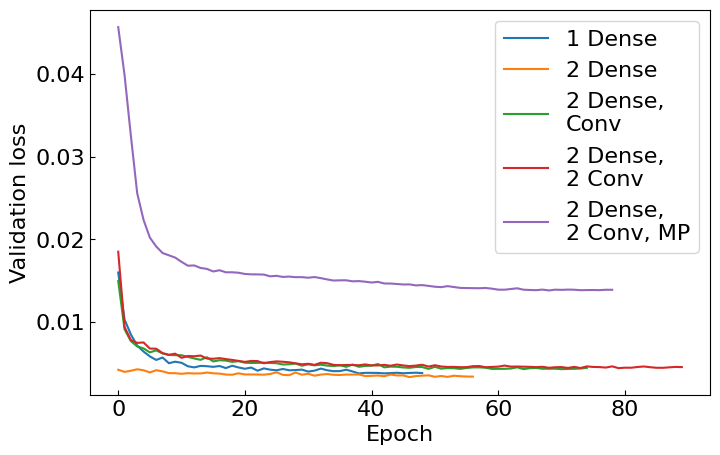

In [95]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.plot(history3.history['val_loss'], label='2 Dense,\nConv')
plt.plot(history4.history['val_loss'], label='2 Dense,\n2 Conv')
plt.plot(history5.history['val_loss'], label='2 Dense,\n2 Conv, MP')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend()

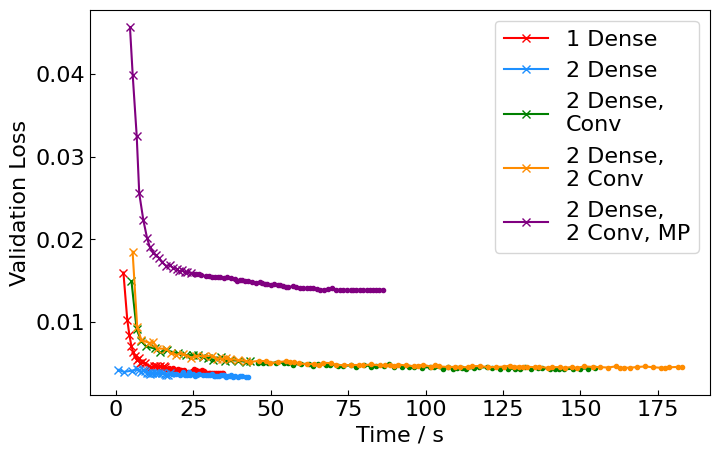

In [96]:
cumulative_times5 = time_callback5.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times3[:20], history3.history['val_loss'][:20], label='2 Dense,\nConv', color='green', linestyle='-', marker='x')
plt.plot(cumulative_times3[20:], history3.history['val_loss'][20:], color='green', linestyle='-', marker='.')
plt.plot(cumulative_times4[:20], history4.history['val_loss'][:20], label='2 Dense,\n2 Conv', color='darkorange', linestyle='-', marker='x')
plt.plot(cumulative_times4[20:], history4.history['val_loss'][20:], color='darkorange', linestyle='-', marker='.')
plt.plot(cumulative_times5[:20], history5.history['val_loss'][:20], label='2 Dense,\n2 Conv, MP', color='purple', linestyle='-', marker='x')
plt.plot(cumulative_times5[20:], history5.history['val_loss'][20:], color='purple', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [97]:
n_tests5, tau_tests5, rho_tests5 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [98]:
epochs5 = len(history5.history['val_loss'])
epochs_saved5 = np.arange(1,epochs5,10)

In [99]:
tau_nns_int5 = predict_with_saved_models(model_saver5.saved_models, epochs_saved5, n_tests5)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [100]:
tau_nns5 = model5_layer.predict(n_tests5)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [101]:
times_saved5, fidelities5, fidelities_err5 = fidelities_epochs(tau_nns5, tau_tests5, tau_nns_int5, epochs_saved5, epochs5, cumulative_times5)

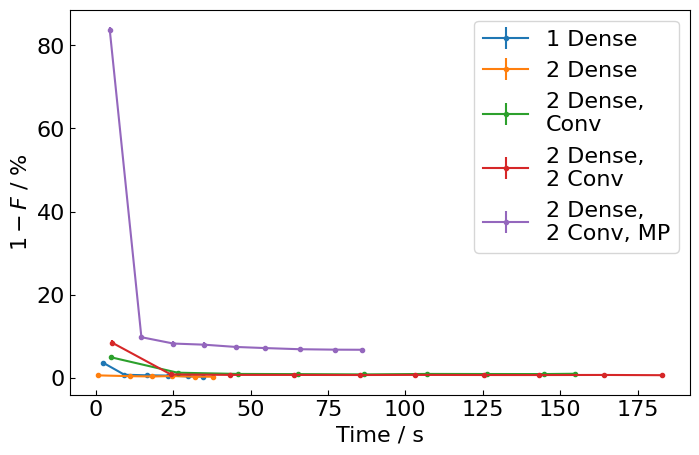

In [102]:
plt.errorbar(times_saved1, (1-fidelities1)*100, yerr=fidelities_err1*100, linestyle = '-', marker='.', label = '1 Dense')
plt.errorbar(times_saved2[:-1], (1-fidelities2[:-1])*100, yerr=fidelities_err2[:-1]*100, linestyle = '-', marker='.', label = '2 Dense')
plt.errorbar(times_saved3, (1-fidelities3)*100, yerr=fidelities_err3*100, linestyle = '-', marker='.', label = '2 Dense,\nConv')
plt.errorbar(times_saved4, (1-fidelities4)*100, yerr=fidelities_err4*100, linestyle = '-', marker='.', label = '2 Dense,\n2 Conv')
plt.errorbar(times_saved5, (1-fidelities5)*100, yerr=fidelities_err5*100, linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, MP')
plt.xlabel('Time / s')
plt.ylabel(r'$1-F$ / %')
plt.legend()
plt.show()

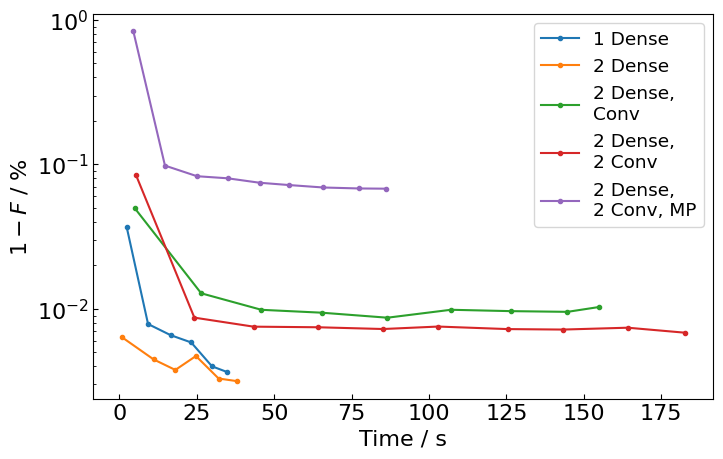

In [103]:
plt.semilogy(times_saved1, (1-fidelities1), linestyle = '-', marker='.', label = '1 Dense')
plt.semilogy(times_saved2[:-1], (1-fidelities2[:-1]), linestyle = '-', marker='.', label = '2 Dense')
plt.semilogy(times_saved3, (1-fidelities3), linestyle = '-', marker='.', label = '2 Dense,\nConv')
plt.semilogy(times_saved4, (1-fidelities4), linestyle = '-', marker='.', label = '2 Dense,\n2 Conv')
plt.semilogy(times_saved5, (1-fidelities5), linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, MP')
plt.xlabel('Time / s')
plt.ylabel(r'$1-F$ / %')
plt.legend(fontsize='small')
plt.show()

In [104]:
def build_cnn_model_6layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((6, 36, 1), input_shape=(6**d,)))

    model.add(Conv2D(filters=25, kernel_size=(2, 2), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=25, kernel_size=(2, 2), activation='relu'))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(dense1, activation='relu'))

    model.add(Dense(dense2, activation='relu'))

    model.add(Dense(2**(2*d), activation='linear'))

    return model

In [108]:
def build_cnn_model_6layers():
    model = Sequential()

    model.add(tf.keras.layers.Reshape((12, 18, 1), input_shape=(6**d,)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
        strides=1
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(
        filters=25,
        kernel_size=(2, 2),
        activation='relu',
        strides=1
    ))

    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())

    model.add(Dense(
        units=dense1,
        activation='relu',
        input_shape=(6**d,)
    ))

    model.add(Dense(
        units=dense2,
        activation='relu'
    ))

    model.add(Dense(
        units=2**(2*d),
        activation='linear'
    ))

    return model

model = build_cnn_model_6layers()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',
    metrics=['mean_absolute_error']
)

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ reshape_12 (Reshape)                 │ (None, 12, 18, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_18 (Conv2D)                   │ (None, 11, 17, 25)          │             125 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 5, 8, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_19 (Conv2D)                   │ (None, 4, 7, 25)            │           2,525 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 2, 3, 25)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_10 (Flatten)                 │ (None, 150)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_42 (Dense)                     │ (None, 2500)                │         377,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_43 (Dense)                     │ (None, 1000)                │       2,501,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_44 (Dense)                     │ (None, 64)                  │          64,064 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,945,214 (11.24 MB)

 Trainable params: 2,945,214 (11.24 MB)

 Non-trainable params: 0 (0.00 B)

In [109]:
nvals6,all_taus6,rhos6 = gen_nvals_taus_rhos(30000,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [110]:
time_callback6 = TimeHistory()

model6_layer = build_cnn_model_6layers()
model6_layer.compile(
    optimizer='adam',
    loss='mean_absolute_error',
    metrics=['mean_squared_error']
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
model_saver6 = InMemoryModelSaver(save_freq_epochs=10)

history6 = model6_layer.fit(
    nvals6, all_taus6,
    epochs=300,
    batch_size=100,
    validation_split=0.2,
    callbacks=[early_stopping, time_callback6, model_saver6]
    )

Epoch 1/300
221/240 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0484 - mean_squared_error: 0.0144
[InMemoryModelSaver] Model cloned and saved in memory at epoch 1.
240/240 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0483 - mean_squared_error: 0.0144 - val_loss: 0.0463 - val_mean_squared_error: 0.0140
Epoch 2/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0461 - mean_squared_error: 0.0139 - val_loss: 0.0452 - val_mean_squared_error: 0.0134
Epoch 3/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0445 - mean_squared_error: 0.0129 - val_loss: 0.0427 - val_mean_squared_error: 0.0120
Epoch 4/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0418 - mean_squared_error: 0.0116 - val_loss: 0.0404 - val_mean_squared_error: 0.0109
Epoch 5/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0396 - mean_squared_error: 0.0105 - val_loss: 0.0383 - val_mean_squared_error: 0.0100
Epoch 6/300
240/240 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0374 - mean_squared_error: 0.0095 - val_l

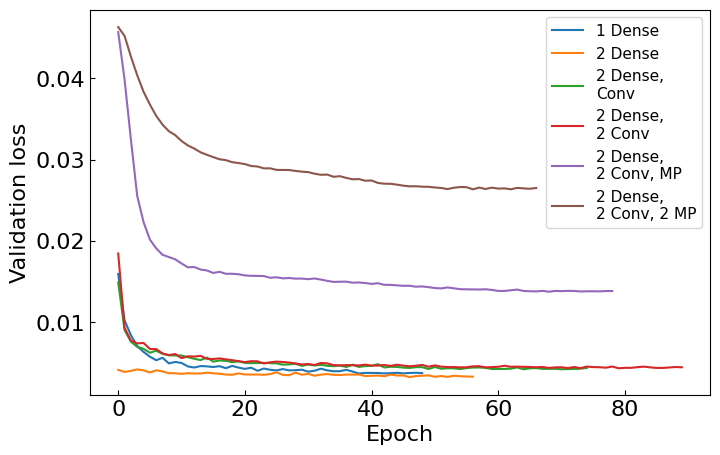

In [111]:
plt.plot(history1.history['val_loss'], label='1 Dense')
plt.plot(history2.history['val_loss'], label='2 Dense')
plt.plot(history3.history['val_loss'], label='2 Dense,\nConv')
plt.plot(history4.history['val_loss'], label='2 Dense,\n2 Conv')
plt.plot(history5.history['val_loss'], label='2 Dense,\n2 Conv, MP')
plt.plot(history6.history['val_loss'], label='2 Dense,\n2 Conv, 2 MP')
plt.xlabel('Epoch')
plt.ylabel('Validation loss')
plt.legend(fontsize='x-small')

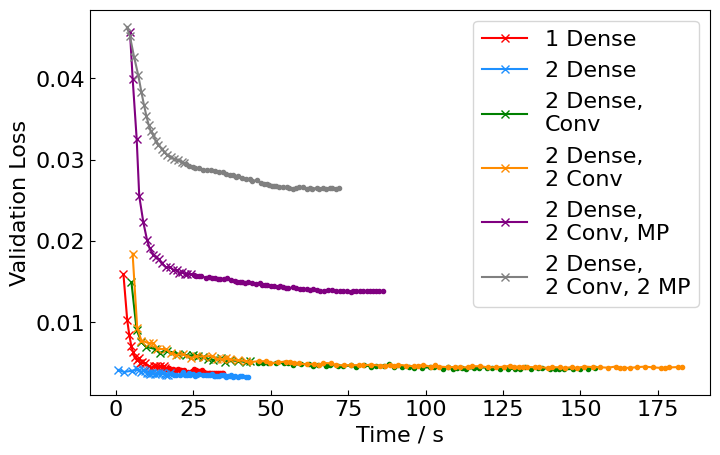

In [112]:
cumulative_times6 = time_callback6.cumulative_times

# plt.title(f'd={d}, dense1={dense1}, dense2={dense2},\nConv(2,2), MaxPool(2,2), Conv(2,2)')
plt.plot(cumulative_times1[:20], history1.history['val_loss'][:20], label='1 Dense', color='red', linestyle='-', marker='x')
plt.plot(cumulative_times1[20:], history1.history['val_loss'][20:], color='red', linestyle='-', marker='.')
plt.plot(cumulative_times2[:20], history2.history['val_loss'][:20], label='2 Dense', color='dodgerblue', linestyle='-', marker='x')
plt.plot(cumulative_times2[20:], history2.history['val_loss'][20:], color='dodgerblue', linestyle='-', marker='.')
plt.plot(cumulative_times3[:20], history3.history['val_loss'][:20], label='2 Dense,\nConv', color='green', linestyle='-', marker='x')
plt.plot(cumulative_times3[20:], history3.history['val_loss'][20:], color='green', linestyle='-', marker='.')
plt.plot(cumulative_times4[:20], history4.history['val_loss'][:20], label='2 Dense,\n2 Conv', color='darkorange', linestyle='-', marker='x')
plt.plot(cumulative_times4[20:], history4.history['val_loss'][20:], color='darkorange', linestyle='-', marker='.')
plt.plot(cumulative_times5[:20], history5.history['val_loss'][:20], label='2 Dense,\n2 Conv, MP', color='purple', linestyle='-', marker='x')
plt.plot(cumulative_times5[20:], history5.history['val_loss'][20:], color='purple', linestyle='-', marker='.')
plt.plot(cumulative_times6[:20], history6.history['val_loss'][:20], label='2 Dense,\n2 Conv, 2 MP', color='gray', linestyle='-', marker='x')
plt.plot(cumulative_times6[20:], history6.history['val_loss'][20:], color='gray', linestyle='-', marker='.')
plt.legend()
plt.xlabel('Time / s')
plt.ylabel('Validation Loss')
plt.show()

In [113]:
n_tests6, tau_tests6, rho_tests6 = gen_nvals_taus_rhos(test_no,d)

<ipython-input-24-f16c7555ff3e>:30: ComplexWarning: Casting complex values to real discards the imaginary part
  nvals[i1,index] = np.trace(rho@proj)


In [114]:
epochs6 = len(history6.history['val_loss'])
epochs_saved6 = np.arange(1,epochs6,10)

In [115]:
tau_nns_int6 = predict_with_saved_models(model_saver6.saved_models, epochs_saved6, n_tests6)

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [116]:
tau_nns6 = model6_layer.predict(n_tests6)

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [117]:
times_saved6, fidelities6, fidelities_err6 = fidelities_epochs(tau_nns6, tau_tests6, tau_nns_int6, epochs_saved6, epochs6, cumulative_times6)

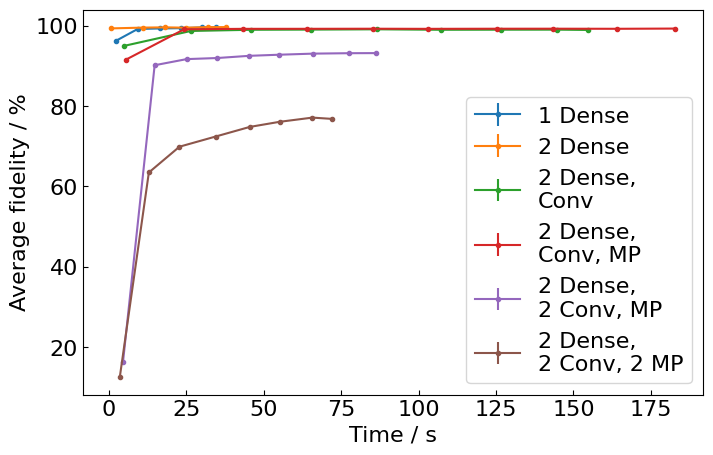

In [118]:
plt.errorbar(times_saved1, (fidelities1)*100, yerr=fidelities_err1, linestyle = '-', marker='.', label = '1 Dense')
plt.errorbar(times_saved2[:-1], (fidelities2[:-1])*100, yerr=fidelities_err2[:-1], linestyle = '-', marker='.', label = '2 Dense')
plt.errorbar(times_saved3, (fidelities3)*100, yerr=fidelities_err3, linestyle = '-', marker='.', label = '2 Dense,\nConv')
plt.errorbar(times_saved4, (fidelities4)*100, yerr=fidelities_err4, linestyle = '-', marker='.', label = '2 Dense,\nConv, MP')
plt.errorbar(times_saved5, (fidelities5)*100, yerr=fidelities_err5, linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, MP')
plt.errorbar(times_saved6, (fidelities6)*100, yerr=fidelities_err6, linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, 2 MP')
plt.xlabel('Time / s')
plt.ylabel('Average fidelity / %')
plt.legend()
plt.show()

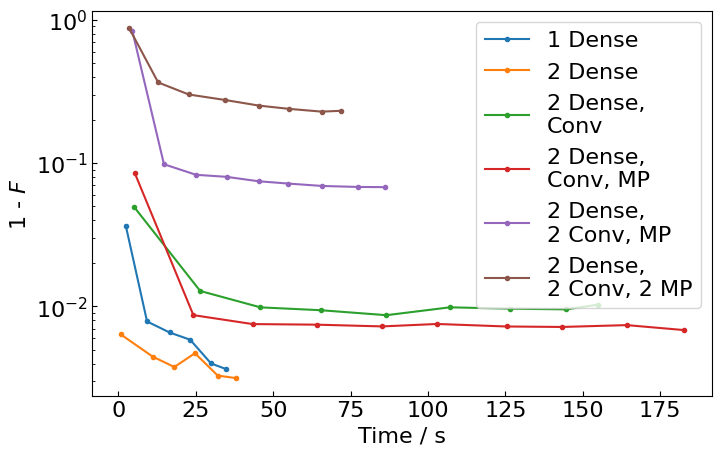

In [121]:
plt.semilogy(times_saved1, (1-fidelities1), linestyle = '-', marker='.', label = '1 Dense')
plt.semilogy(times_saved2[:-1], (1-fidelities2[:-1]), linestyle = '-', marker='.', label = '2 Dense')
plt.semilogy(times_saved3, (1-fidelities3), linestyle = '-', marker='.', label = '2 Dense,\nConv')
plt.semilogy(times_saved4, (1-fidelities4), linestyle = '-', marker='.', label = '2 Dense,\nConv, MP')
plt.semilogy(times_saved5, (1-fidelities5), linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, MP')
plt.semilogy(times_saved6, (1-fidelities6), linestyle = '-', marker='.', label = '2 Dense,\n2 Conv, 2 MP')
plt.xlabel('Time / s')
plt.ylabel(r'1 - $F$')
plt.legend()
plt.show()

In [ ]:
save_dir = '/content/drive/MyDrive'

In [ ]:
import os

model_save_path = os.path.join(save_dir, '2d_trained_model.keras')

In [ ]:
model1.save(model_save_path)

In [ ]:
tau_nn = model.predict(nvals_t)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


In [ ]:
print(no_data,d)

30000 2


In [ ]:
fidelity(test_rhos[0], rho_nn)

0.99948127099706151087